# Project Topic:
Is it possible to extract market trends automatically from the published data? For a consulting company like Futurice, it is important to understand emerging business trends and the market situation of client companies. 

The data we have available is from the [Edgar Database](https://www.sec.gov/edgar/searchedgar/companysearch.html) in form of annual reports (10-K format). The data source contains the annual financial report of all registered companies in the USA. 

# Our task: 
- Explore publicly available textual financial datasets using Machine Learning methods. 
- Create visualizations to highlight the most important trends in the data.

In [13]:
%load_ext autoreload
%autoreload 2
import requests
import os
import re
import pandas as pd
from pathvalidate import sanitize_filename
from bs4 import BeautifulSoup
from download_edgar import * 
from utils import *
from topic_modeling import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Acquisition

## Download Data 

In [2]:
# Download index files from start-year to end-year
download_index(2010, 2019)

## Tag Stripping

In [3]:
# Clean the tags from the file
clean_index()

Stripping unnecessary tags from the text file for year 2013
Stripping unnecessary tags from the text file for year 2014
Stripping unnecessary tags from the text file for year 2015
Stripping unnecessary tags from the text file for year 2012
Stripping unnecessary tags from the text file for year 2017
Stripping unnecessary tags from the text file for year 2010
Stripping unnecessary tags from the text file for year 2018
Stripping unnecessary tags from the text file for year 2011
Stripping unnecessary tags from the text file for year 2016


## Download 10-K reports

In [7]:
download_10_k(2010, 2019)

# Data Engineering

## Convert 10-K reports to CIK series

In [12]:
rename_to_index(2010, 2019)

Converting 10-K to CIK for year 2010
Converting 10-K to CIK for year 2011
Converting 10-K to CIK for year 2012
Converting 10-K to CIK for year 2013
Converting 10-K to CIK for year 2014
Converting 10-K to CIK for year 2015
Converting 10-K to CIK for year 2016
Converting 10-K to CIK for year 2017
Converting 10-K to CIK for year 2018


## Data pre-processing 

The original text is in the following form: 

In [1]:
#Read the text from uncleanned file
f=open("forms/2010/1853.txt", "r")
print(f.read(200))

 -k motivnationform kdec htm movt form k december motivnationform kdec htm united states securities and exchange commission washington d c form -k x annual report under section or d of the securities 


### Pre-processing the data with the following tasks:
+ Remove stopwords
+ Convert the text to lower case, strip punctuation, and split by spaces
+ Lemmatize the text to its root form

In [3]:
preprocess(2010, 2019)

Pre-processing the data for year 2010
Pre-processing the data for year 2011
Pre-processing the data for year 2012
Pre-processing the data for year 2013
Pre-processing the data for year 2014
Pre-processing the data for year 2015
Pre-processing the data for year 2016
Pre-processing the data for year 2017
Pre-processing the data for year 2018


After being pre-processed, the data is in the following form, which is sufficient for Natural Language Processing:

In [4]:
a=open("cleaned/2010/1853.txt", "r")
print(a.read(200))

motivnationform kdec movt form decemb motivnationform kdec unit state secur exchang commiss washington form annual report section secur exchang fiscal year end decemb transit report pursuant section s


## Classify companies into corresponding industries

The industry a company belongs to could be queried in the [Edgar Database](https://www.sec.gov/info/edgar/siccodes.htm) using the company's SIC code.   
#### Code Description:
- CIK is the company's ID in Edgar database.
- SIC is the company's business sector code defined in Edgar.

Convert the CIK code to SIC code and use it to query in the database:

In [8]:
#Convert the CIK to SIC
cik_2_sic = CIK_2_SIC_series

#Classify the company into its industry
classify_industry(2010,2019)


Classifying companies into industries for year 2010
Classifying companies into industries for year 2011
Classifying companies into industries for year 2012
Classifying companies into industries for year 2013
Classifying companies into industries for year 2014
Classifying companies into industries for year 2015
Classifying companies into industries for year 2016
Classifying companies into industries for year 2017
Classifying companies into industries for year 2018


# Topic modeling 

### Query Corpus For Training 
There are 2 scenarios:
1. Query all available companies in all years. In this way, we can cover more textual data and obtain a comprehensive collection of topics. However, there might be the case that some trendy topics actually represent changes in the number of registered companies, rather than represent how companies are changing their business.
2. Query only a subset of companies that appear in every years. In this way, we can study how topics of the same set of companies change over time. Nonetheless, we might lose considerable amount of information as the companies intersection over years can be small compared to the original data.

In [8]:
# Choose some parameters as a example:
office = 'Office of Manufacturing'
sector = 'Foods & Beverages'
start_year = 2010
end_year = 2019
same_companies = False
use_perplexity = False

In [14]:
# Get the corpus:
if same_companies:
    corpus = query_intersection(2010, 2019, office, sector, False)
else:
    corpus = query_docs(2010, 2019, office, sector, False)

Querying the document for companies in year 2010
Querying the document for companies in year 2011
Querying the document for companies in year 2012
Querying the document for companies in year 2013
Querying the document for companies in year 2014
Querying the document for companies in year 2015
Querying the document for companies in year 2016
Querying the document for companies in year 2017
Querying the document for companies in year 2018


### Sample Documents
The topic model should be general enough to achieve reasonable prediction. Therefore, training documents for the topic model should contains a random subset of documents from each year.  

In [16]:
# Sampling documents in each year for training:
docs = sampling_corpus(corpus, percent=1/(end_year - start_year))

### Training Topic Models
Latent Dirichlet Allocation (LDA) topic model (gensim) is used for topic modeling. Because LDA model depends significantly on the number of topics in a document, we trained several models on different number of topics and chose the best one based on their coherence scores and perplexity scores.

In [18]:
# Covert documents to tokens, bag of word and dictionary format:
texts, bows, dic, bigram = texts_bows_dict(docs, 5, 0.5, 5, 100, True)
    
# Build models for comparison:
start = max(len(docs) - 70, 10)
end = len(docs) + 1
step = 10
models, coherences, perplexities = models_codherence_perplexity(
        texts, bows, dic, topic_start=start, topic_end=end, step=step, \
        chunk=20, passes=3)

# Choose a good model:
if use_perplexity:
    per = [-p for p in perplexities]
    per = [(p - min(per))/(max(per) - min(per)) for p in per]
    score = [per[i]*coherences[i] for i in range(len(per))]
    which = np.argmax(score)
else:
    which = np.argmax(coherences)
chosen = models[which]

Building model of 83 topics
Building model of 93 topics
Building model of 103 topics
Building model of 113 topics
Building model of 123 topics
Building model of 133 topics
Building model of 143 topics
Building model of 153 topics


### Topic Analysis
1. A subset of topics will be chosen as preference for topic analysis because many topics are either similar to each others or hard to interpret in human level. Chosen topics should have high coherence or low correlation. To that end, top topics from both criteria are selected and then we take the union of them.
2. Chosen LDA model is used to predict most probable topics for each document. The set of predicted topics will be processed in such a way that any topic which is not a member of the union will be replaced by a topic in the union that is most correlated to it.
3. Count the occurrence of each topic in each year in the corpus.

In [ ]:
# Get texts and bows for each year:
bows_vs_years = get_all_bows(corpus, dic, bigram)

# Prepare to get topic union:
topic_list = chosen.show_topics(chosen.num_topics, 10)
top_topics = chosen.top_topics(texts=texts, coherence='c_v', topn=10)
    
# Get the correlation matrix:
mdiff, _ = chosen.diff(chosen, distance='jaccard', num_words=100)
    
# Get top topics based on coherence and correlation:
union = topic_union(top_topics, topic_list, mdiff, 10)
    
# Get the count for each topic in each year:
counts = topic_count_years(bows_vs_years, chosen, 0.05, union, mdiff)

### Data Saving
After the topic analysis, we stored the result in csv files as sources for data visualization.

In [ ]:
# Get DataFrame:
data = [[p[1] for p in count] for count in counts]
pre = [' | '.join(re.findall(r'[a-z_]+', topic_list[i][1])) \
        for i in union]
df = pd.DataFrame(data, columns=pre, index=range(2010, 2019))
# Save the model:
df.to_csv(os.getcwd()[:-14] + '/web/source/' + office + '_' + sector + '.csv')

# Data Visualization

The following image is the change in the number of times a topic was mentioned in the Food & Beverages sector of the Office of Manufacturing (158 companies):

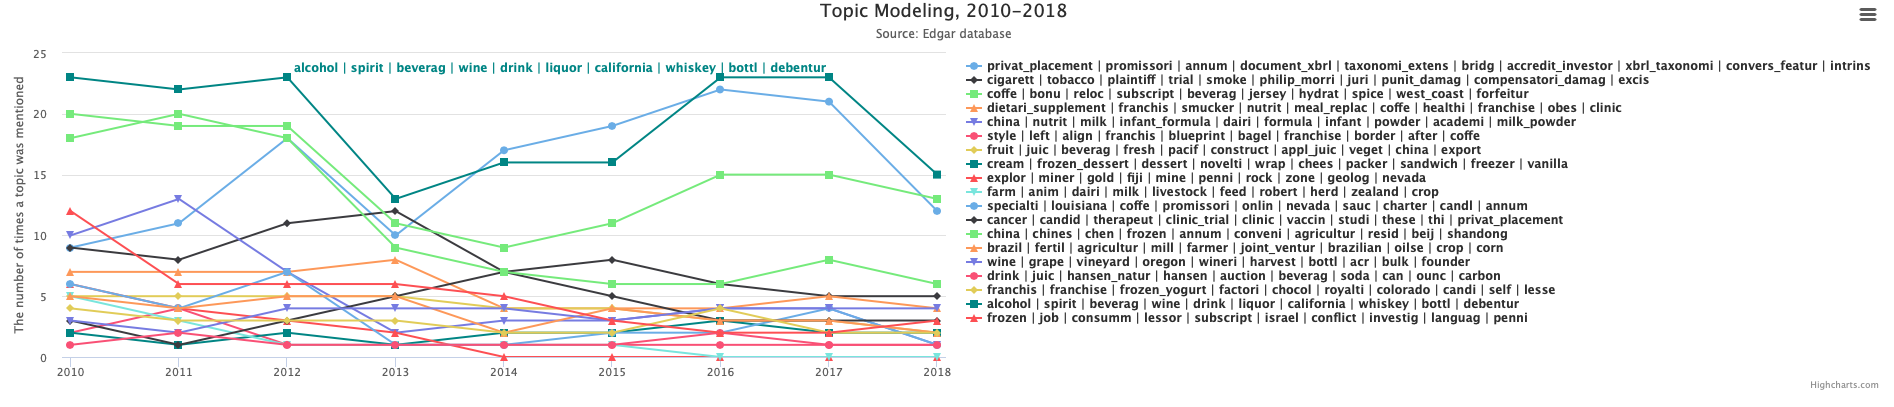

## Ask question: How to detect potential trends that happened in the past?
## Starting point:
At this point, it is necessary to remove the lines that remain stable over the 9-year period. It could be assumed that those lines are unlikely to be trendy in the future, and companies would be mentioning about those topics with similar frequencies. 

## Features and Labels and Convert Data to Arrays

In [27]:
# Use numpy to convert to arrays
import numpy as np

# Use pandas to read csv files
import pandas as pd

# Use three sectors as the training data
vehicles_sector = pd.read_csv("Office of Manufacturing_Vehicles.csv").drop(columns = "Unnamed: 0")
electronic_sector = pd.read_csv("Office of Manufacturing_ELectrical & Electronic.csv").drop(columns = "Unnamed: 0")
recreational_sector = pd.read_csv("Office of Trade & Services_Recreational Services.csv").drop(columns = "Unnamed: 0")
train_data = pd.concat([vehicles_sector,electronic_sector,recreational_sector],axis=1).T

# Convert features to array
features = np.array(train_data)

Here it is assuming that the topic which differed by at least 10 times in the number of times being mentioned was trendy and could reveal interesting things happened in the past. We manually labelled the test data (0: uninteresting, 1: interesting) through visualizing the high chart as following:

In [28]:
# Convert labels to array 
labels_vehicles = np.array([0,0,0,0,1,0,0,1,0,0,0,0,1,0,0])
labels_electronic = np.array([0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0])
labels_recreational = np.array([0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1])

labels = np.concatenate([labels_vehicles, labels_electronic, labels_recreational])

## Training and testing sets

In [11]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training set and testing set
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 66)

In [12]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (39, 9)
Training Labels Shape: (39,)
Testing Features Shape: (14, 9)
Testing Labels Shape: (14,)


## Train the model

In [13]:
# Import libraries for the Random Forest Algorithm 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Instantiate the model
rfc = RandomForestClassifier(n_estimators=100, max_depth=3,random_state=42)

# Train the model
rfc.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

## Make predictions on Test data

In [16]:
# Use the forest's predict method on the test data
predictions = rfc.predict(test_features)
predictions

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Determine Performance Metrics

In [25]:
#Test the accuracy of the model 
accuracy = rfc.score(test_features, test_labels)
print("Accuracy: ", round(accuracy,2) * 100, '%.')

Accuracy:  93.0 %.


## Improve the Model if necessary

We can create models with different hyperparameters to try and boost performance. The only way to find the best ones are to try a few and evaluate them!

In [29]:
rfc_new = RandomForestClassifier(n_estimators=100, max_depth=20,random_state=42)